# Sidekick - Mixture of Least Squares
We train a mixture of least squares, experimenting with different number of components.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16,14)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from dataset import Sidekick
from model import LeastSquaresMixture
from math import floor
from sklearn import linear_model

DATA_DIR = "../data/sidekick"

def subsample(t0, t1, n_samples):
    t = t1 - t0
    if n_samples >= t:
        return range(t0, t1)
    samples = range(t0, t1, int(np.ceil(t / float(n_samples))))
    return samples

## Load and split data

In [2]:
sk = Sidekick()
sk.load()
projects_train, projects_test = sk.split(threshold=0.7)
total = len(projects_train) + len(projects_test)

Loading data set...
Data loaded.


### Visualize projects at different times

[ 0.0625      0.07241379  0.0004      0.18425264  0.0105    ]
[ 0.0725      0.08241379  0.0104      0.19425264  0.0205    ]
[-2.62416872 -2.49600246 -4.56594947 -1.63859568 -3.88733039]
[ 0.25        0.26909811  0.02        0.4292466   0.10246951]


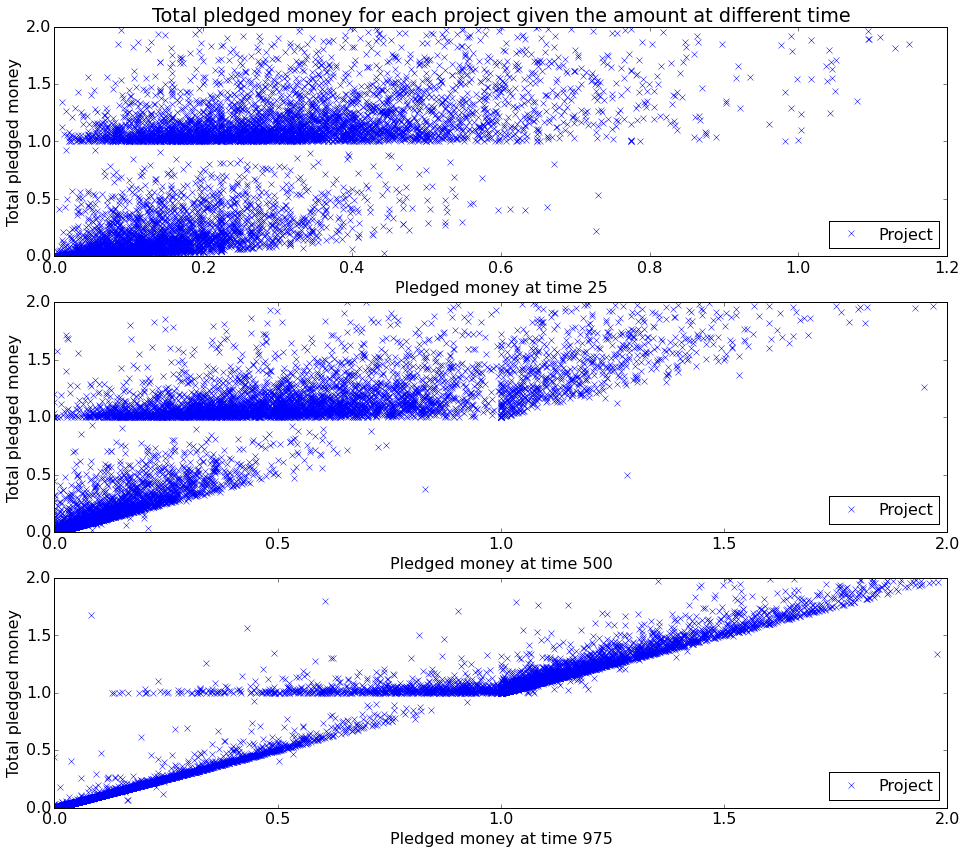

In [50]:
T = 999

plt.figure(2)
outlier_threshold = 2

plt.subplot(311)
t = 25
yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and p.money[t] > 0]
print(np.array(yt[:5]))
yt_scale = np.array(yt) + 0.01
print(yt_scale[:5])
yt_log = np.log(yt_scale)
print(yt_log[:5])
yt_sqrt = np.sqrt(yt)
print(yt_sqrt[:5])
yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and p.money[t] > 0]
plt.plot(yt_sqrt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)
plt.title('Total pledged money for each project given the amount at different time')

plt.subplot(312)
t = 500
yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)

plt.subplot(313)
t = 975
yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)


plt.savefig('final_money_vs_pledged_money.pdf')
plt.show()

## Data processing

In [131]:
#N = 16000
#N_train = int(floor(0.8*N))
seed = 2
t0 = 1
t1 = 975
n_samples = 1
T = 999

samples = subsample(t0, t1, n_samples)
t = len(samples)
samples = t1 - 1

#N_projects = sk.choose_n_projects(n=N, seed=seed)
#projects_train = N_projects[:N_train]
#projects_test = N_projects[N_train:]

# Remove outliers
outlier_threshold = 2  # Ignore the project whose total pledged money if more that o_t times their goal
projects_train_filtered = [p for p in projects_train if p.money[T] < outlier_threshold and p.money[samples] < outlier_threshold and p.money[samples] >= 0]
projects_test_filtered = [p for p in projects_test if p.money[T] < outlier_threshold and p.money[samples] < outlier_threshold and p.money[samples] >= 0]
#projects_test_filtered = projects_test

X_train = np.ndarray(shape=(len(projects_train_filtered), t), buffer=np.array([p.money[samples] for p in projects_train_filtered]), dtype=float) 
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
X_test = np.ndarray(shape=(len(projects_test_filtered), t), buffer=np.array([p.money[samples] for p in projects_test_filtered]), dtype=float) 
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)

# Required to contain the prediction in a reasonable range
# The problem arises when evaluating the likelihood in the expression for gamma_nk
#X_max = np.max(X_train, axis=0)
#X_train = X_train / X_max[np.newaxis, :]
# Apply same preprocessing to testing set
#X_test = X_test / X_max[np.newaxis, :]  

total_filtered = len(X_train) + len(X_test)
print("Removed %0.2f%% outliers" % (100 - total_filtered / total * 100))
print("Training on %s projects (%0.2f%%)" % (len(X_train), len(X_train) / total_filtered * 100))
print("Testing on %s projects (%0.2f%%)" % (len(X_test), len(X_test) / total_filtered * 100))
print("Number of features: %s" % n_samples)

Removed 7.15% outliers
Training on 10342 projects (70.06%)
Testing on 4420 projects (29.94%)
Number of features: 1


## Training

### Simple Training

In [132]:
K = 2
beta = 1 / np.var(y_train)
epsilon = 1
lam = 0
iterations = 1000
random_restarts = None

mls1 = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls1.train(verbose=True)

#mls1.w[0, 0] = 0.04254392
#mls1.w[1, 0] = 2.62458562
#mls1.pi[0] = 0.5
#mls1.beta[0] = 86.3519133
#mls1.w[0, 1] = 1.12565788
#mls1.w[1, 1] = 0.54935766
#mls1.pi[1] = 0.5
#mls1.beta[1] = 2.44219068e+01
#mls1.trained = True

print(mls1)

# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)
# The coefficients
print('Linear regression coefficients:', regr.intercept_, regr.coef_)

* Starting EM algorithm for mixture of K=2 least squares models
* Beta = [ 3.07795875  3.07795875]
* Lambda = 0
* Running at most 1000 iterations
* Stopping when complete likelihood improves less than 1
       Obj       pi1       pi2       w11       w12       w21       w22     beta1     beta2
      -inf      0.50      0.50      0.96      0.34      0.57      0.42      3.08      3.08
   1736.01      0.39      0.61      0.03      1.03      0.01      1.04      1.53      2.38
   3634.18      0.34      0.66      0.02      1.04      0.02      1.04     31.70     60.87
  17889.74      0.30      0.70      0.05      1.04      0.00      1.04     27.91     65.36
  18355.10      0.25      0.75      0.07      1.04      0.00      1.04     24.49     75.40
  19059.91      0.19      0.81      0.10      1.04      0.00      1.04     19.65     85.41
  19747.27      0.13      0.87      0.14      1.04      0.00      1.04     15.04     97.89
  20446.20      0.09      0.91      0.21      1.01      0.00      1.0

In [133]:
X_train2 = np.sqrt(X_train)
X_test2 = np.sqrt(X_test)

K = 2
beta = 1 / np.var(y_train)
#beta = 0.0001
epsilon = 1e0
lam = 0
iterations = 1000
random_restarts = None

mls2 = LeastSquaresMixture(X_train2, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls2.train(verbose=True)

print(mls2)

# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train2, y_train)
# The coefficients
print('Linear regression coefficients:', regr.intercept_, regr.coef_)

* Starting EM algorithm for mixture of K=2 least squares models
* Beta = [ 3.07795875  3.07795875]
* Lambda = 0
* Running at most 1000 iterations
* Stopping when complete likelihood improves less than 1.0
       Obj       pi1       pi2       w11       w12       w21       w22     beta1     beta2
      -inf      0.50      0.50      0.61      0.52      0.87      0.17      3.08      3.08
   1119.65      0.56      0.44     -0.16      1.26     -0.18      1.28      1.89      1.49
   2626.70      0.59      0.41     -0.17      1.27     -0.17      1.27     28.54     20.09
  13985.60      0.61      0.39     -0.17      1.26     -0.17      1.28     29.64     19.09
  14030.18      0.63      0.37     -0.17      1.26     -0.17      1.29     31.02     17.87
  14093.21      0.67      0.33     -0.17      1.25     -0.17      1.29     32.69     16.38
  14178.06      0.70      0.30     -0.17      1.25     -0.17      1.30     34.69     14.61
  14289.88      0.75      0.25     -0.17      1.25     -0.17      1

In [134]:
c = 0.01
X_train3 = np.log(X_train + c)
X_test3 = np.log(X_test + c)

K = 2
beta = 1 / np.var(y_train)
#beta = 0.0001
epsilon = 1e0
lam = 0
iterations = 1000
random_restarts = None

mls3 = LeastSquaresMixture(X_train3, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls3.train(verbose=True)

print(mls3)

# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train3, y_train)
# The coefficients
print('Linear regression coefficients:', regr.intercept_, regr.coef_)

* Starting EM algorithm for mixture of K=2 least squares models
* Beta = [ 3.07795875  3.07795875]
* Lambda = 0
* Running at most 1000 iterations
* Stopping when complete likelihood improves less than 1.0
       Obj       pi1       pi2       w11       w12       w21       w22     beta1     beta2
      -inf      0.50      0.50      0.81      0.19      0.33      0.33      3.08      3.08
   2391.52      0.70      0.30      1.08      0.28      1.01      0.32      2.98      1.29
   3905.24      0.77      0.23      1.05      0.28      1.05      0.29     11.84      3.56
   8503.80      0.82      0.18      1.04      0.28      1.08      0.30     13.21      2.91
   8717.45      0.87      0.13      1.04      0.28      1.12      0.32     14.09      2.14
   8855.64      0.91      0.09      1.04      0.28      1.16      0.33     14.89      1.42
   8977.42      0.95      0.05      1.04      0.28      1.21      0.35     15.52      0.83
   9074.12      0.97      0.03      1.04      0.28      1.27      0

### Display weights

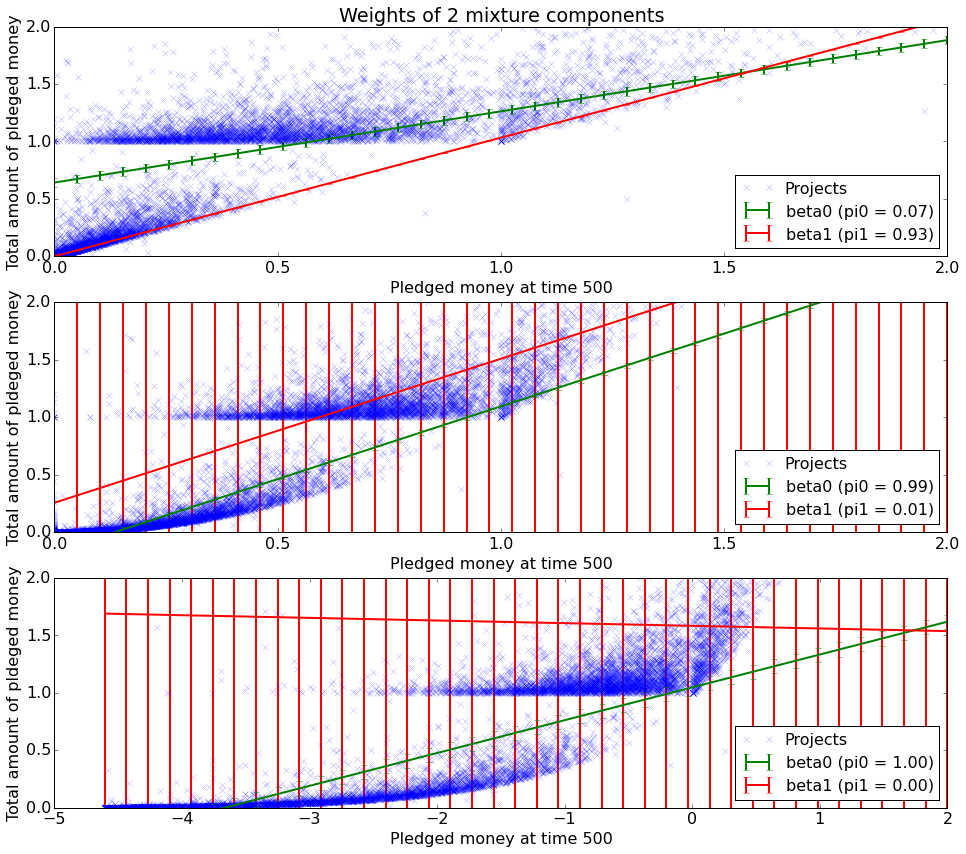

In [135]:
projects = True
n_points = 40
K = 2

x = np.ones((n_points, 2))
x[:, 1] = np.linspace(0, outlier_threshold, n_points)

y1 = []
for k in range(K):
    w_k = mls1.w[:, k]
    y1.append(x.dot(w_k))

y2 = []
for k in range(K):
    w_k = mls2.w[:, k]
    y2.append(x.dot(w_k))

x3 = np.ones((n_points, 2))
x3[:, 1] = np.linspace(np.log(c), outlier_threshold, n_points)
y3 = []
for k in range(K):
    w_k = mls3.w[:, k]
    y3.append(x3.dot(w_k))

plt.figure(1)

plt.subplot(311)
t = 500
if projects:
    yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and p.money[t] >= 0]
    yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and p.money[t] >= 0]
    plt.plot(yt, yT, 'x', label="Projects", alpha=0.3)
for k in range(K):
    plt.errorbar(x[:, 1], y1[k], x[:, 0] / mls1.beta[k], label="beta%s (pi%s = %0.2f)" % (k, k, mls1.pi[k],), lw=2)
plt.title("Weights of %s mixture components" % K)
plt.xlabel("Pledged money at time %s" % t)
plt.ylabel("Total amount of pldeged money")
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend(loc='best')

plt.subplot(312)
t = 500
if projects:
    yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and p.money[t] >= 0]
    yt = np.sqrt(yt)
    yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and p.money[t] >= 0]
    plt.plot(yt, yT, 'x', label="Projects", alpha=0.3)
for k in range(K):
    plt.errorbar(x[:, 1], y2[k], x[:, 0] / mls2.beta[k], label="beta%s (pi%s = %0.2f)" % (k, k, mls2.pi[k],), lw=2)
plt.xlabel("Pledged money at time %s" % t)
plt.ylabel("Total amount of pldeged money")
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend(loc='best')

plt.subplot(313)
t = 500
if projects:
    yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and p.money[t] > 0]
    yt = np.log(np.array(yt) + c)
    yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold and p.money[t] > 0]
    plt.plot(yt, yT, 'x', label="Projects", alpha=0.3)
for k in range(K):
    plt.errorbar(x3[:, 1], y3[k], x3[:, 0] / mls3.beta[k], label="beta%s (pi%s = %0.2f)" % (k, k, mls3.pi[k],), lw=2)
plt.xlabel("Pledged money at time %s" % t)
plt.ylabel("Total amount of pldeged money")
#plt.xlim([0, 3])
plt.ylim([0, 2])
plt.legend(loc='best')

plt.savefig("weights.pdf")
plt.show()

## Testing

### Full Test Set

In [136]:
rmse_failed, rmse_success, rmse, accuracy = mls1.evaluate(X_test, y_test, verbose=True)

Evaluating model LeastSquaresMixture (2 components)...
Data point (4420/4420): [####################] 100% Elapsed time: 0:00:02
Accuracy     : 0.9287330316742082
RMSE         : 0.101538443632
RMSE failed  : 0.0509276352807
RMSE success : 0.143005233927


In [137]:
rmse_failed, rmse_success, rmse, accuracy = mls2.evaluate(X_test2, y_test, verbose=True)

Evaluating model LeastSquaresMixture (2 components)...
Data point (4420/4420): [####################] 100% Elapsed time: 0:00:01
Accuracy     : 0.9506787330316742
RMSE         : 0.13830380074
RMSE failed  : 0.138612571688
RMSE success : 0.13789698241


In [138]:
rmse_failed, rmse_success, rmse, accuracy = mls3.evaluate(X_test3, y_test, verbose=True)

Evaluating model LeastSquaresMixture (2 components)...
Data point (4420/4420): [####################] 100% Elapsed time: 0:00:02
Accuracy     : 0.9547511312217195
RMSE         : 0.244863054666
RMSE failed  : 0.269422911544
RMSE success : 0.208229052891


### Single Point

In [130]:
test = 1
x_new = X_test3[test]
y_new = mls3.predict(x_new, posteriors=True)
y_true = y_test[test]
print("Predicted:  %s" % y_new)
#print("Posteriors: %s" % ["%0.2f%%" % (p * 100) for p in y_posteriors])
print("Actual:     %s" % y_true[0])

Predicted:  0.978019502765
Actual:     0.59685137518


### Predictive Distribution

Predicted: 0.64599279396
Actual: 0.283377793978
pi_k: [ 0.5  0.5]


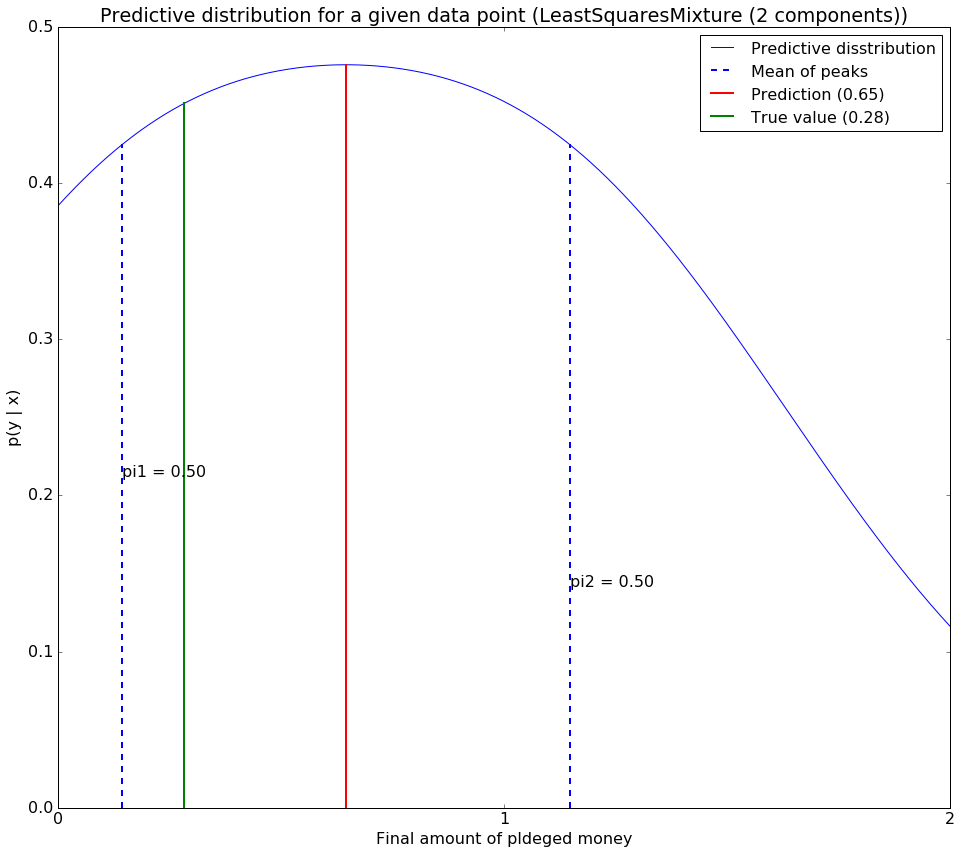

In [48]:
def predictive_distribution(mls, x, y):
    p = 0
    for k in range(mls.K):
        pi_k = mls.pi[k]
        beta_k = mls.beta[k]
        w_k = mls.w[:, k]
        p += pi_k * np.sqrt(beta_k / (2 * np.pi)) * np.exp(- beta_k / 2 * (y - np.dot(tx, w_k))**2)
    return p

mls = mls1

test = 2
outlier_threshold = 2
x_new = X_test[test]
y_new = mls.predict(x_new, posteriors=True)
y_true = y_test[test]

tx = np.ones((1, len(x_new ) + 1))
tx[0, 1:] = x_new
y = np.linspace(0, outlier_threshold, 1000)
py = predictive_distribution(mls, tx, y)

print("Predicted:", y_new)
print("Actual:", y_true[0])
print("pi_k:", mls.pi)

m1 = np.dot(tx, mls.w[:, 0])[0]
beta1 = mls.beta[0]
pi1 = mls.pi[0]
m2 = np.dot(tx, mls.w[:, 1])[0]
beta2 = mls.beta[1]
pi2 = mls.pi[1]

plt.figure()
plt.plot(y, py, label="Predictive disstribution")
plt.plot((m1, m1), (0, predictive_distribution(mls, tx, m1)), 'b--', lw=2)
plt.plot((m2, m2), (0, predictive_distribution(mls, tx, m2)), 'b--', lw=2, label="Mean of peaks")
plt.plot((y_new, y_new), (0, predictive_distribution(mls, tx, y_new)), 'r', lw=2, label="Prediction (%0.2f)" % y_new)
plt.plot((y_true, y_true), (0, predictive_distribution(mls, tx, y_true)), 'g', lw=2, label="True value (%0.2f)" % y_true)
plt.text(m1, predictive_distribution(mls, tx, m1) / 2, "pi1 = %0.2f" % mls.pi[0])
plt.text(m2, predictive_distribution(mls, tx, m2) / 3, "pi2 = %0.2f" % mls.pi[1])
plt.xticks(np.arange(min(y), max(y)+1, 1.0))
plt.title("Predictive distribution for a given data point (%s)" % mls.name)
plt.xlabel("Final amount of pldeged money")
plt.ylabel("p(y | x)")
plt.legend(loc=1)
plt.savefig("predictive_distribution.pdf")
plt.show()

### Grid Search Training

In [ ]:
K = 3
epsilon = 1e-2
iterations = 1000
random_restarts = 10
betas = np.array([1/np.var(y_train)])
lambdas = np.logspace(-8, 2, 50)
lambdas = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
k_fold = 2

mls = LeastSquaresMixture(X_train, y_train, K=K,
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
rmse_avg, rmse_std, accuracy_avg, accuracy_std = mls.grid_search(betas, lambdas, k_fold=k_fold)

print(mls)